In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score

from tqdm.auto import tqdm
# import scipy.sparse    # 稀疏矩阵的处理
# import pickle


# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Data

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample_submit = pd.read_csv('input/sample_submit.csv')

In [3]:
train.head()

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.50,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.33,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.00,1991,2019,13,1,28,0
3,54688,43,13,6,1867106,2484678,2486856,0,0,0,...,0,0,1.00,1.42,1964,2019,3,1,55,0
4,63894,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1995,2019,-1,0,24,0


# Train

In [4]:
X = train.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','loan_default'],axis=1)
y = train['loan_default']
X_test = test.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1)

In [5]:
def prob_to_label(x,threshold):
    labels = x.copy()
    labels[labels<threshold]=0
    labels[labels>=threshold]=1
    return labels

# (440000 + 165000*(1 - np.exp((-0.3) * x / 6)))

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def f1_score_custom(y_true, y_pred):
    y_pred = y_pred.round()
    return 'f1', f1_score(y_true, y_pred,average='macro'), True

def floss(prediction, target, beta=1, log_like=False):
    EPS = 1e-10
    # print(prediction)
    N = prediction.size
    TP = (prediction * target).sum()
#     TP = np.logical_and(prediction,target).sum()
    H = beta * target.sum() + prediction.sum()
    fmeasure = (1 + beta) * TP / (H + EPS)
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_  = (1 - fmeasure)
    return floss_

def floss_macro(prediction, target, beta=1, log_like=False):
    EPS = 1e-10
    prediction_inv = np.logical_not(prediction)
    target_inv = np.logical_not(target)
    
    TP_0 = (prediction_inv * target_inv).sum()
    H_0 = beta * target_inv.sum() + prediction_inv.sum()
    fmeasure_0 = (1 + beta) * TP_0 / (H_0 + EPS)
    
    TP_1 = (prediction * target).sum()
    H_1 = beta * target.sum() + prediction.sum()
    fmeasure_1 = (1 + beta) * TP_1 / (H_1 + EPS)
    
    fmeasure = (fmeasure_0+fmeasure_1)/2
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_  = - fmeasure
    return floss_

def floss_macro_2(prediction, target):
    return -f1_score(target,prediction,average='macro')
    


def feval_floss(preds, lgbm_train,threshold):
    labels = lgbm_train.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    return 'floss', round(floss(target = labels, prediction = preds),5), False

def feval_floss_macro(preds, lgbm_train):
    labels = lgbm_train.get_label()
#     print('labels_sum: ',labels.sum())
#     print(preds)
    preds = prob_to_label(preds,threshold=threshold)
#     print('pred_sum: ',preds.sum())
#     print(round(floss_macro(target = labels, prediction = preds),5))
    return 'floss_macro', round(floss_macro(target = labels, prediction = preds),5), False

def feval_floss_macro_xgb(preds, train_matrix):
    labels = train_matrix.get_label()
#     print('labels_sum: ',labels.sum())
    print(preds)
    preds = prob_to_label(preds,threshold=threshold)
#     print('pred_sum: ',preds.sum())
#     print(round(floss_macro(target = labels, prediction = preds),5))
    return 'floss_macro', round(floss_macro(target = labels, prediction = preds),5)

# def evalmcc(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'MCC', matthews_corrcoef(labels, preds > THRESHOLD)


def feval_floss_macro_2(preds, lgbm_train):
    labels = lgbm_train.get_label()
    preds = prob_to_label(preds,threshold=threshold)
    return 'floss_macro_sk', round(floss_macro_2(target = labels, prediction = preds),5), False


In [6]:
base_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric':'None', # (lambda y_true, y_pred: f1_score_custom(y_true, y_pred)),
            'min_child_weight': 5,
            'num_leaves': 2 ** 7,
            'early_stopping_rounds':200,
            'lambda_l2': 10,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 4,
            'learning_rate': 0.01,
            'seed': 2021,
            'n_jobs':-1,
            'verbose': -1,
        }

lgbm_params = {
            # Key Parameters
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt', # 'dart'
            'learning_rate': 0.01,
#             'num_iterations':100  # default=100
            'early_stopping_rounds':200,    
#             'min_child_weight': 5, #叶子上的最小样本数
#             'max_depth': default=-1
#             'num_leaves': 2 ** 7,  # default = 31(2**5-1)
            'num_threads': -1, # 'n_jobs'
                
            # Learning Control Parameters
#             'lambda_l1':
            'lambda_l2': 10,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 4,
    
            'verbose': -1,
            'seed': 2021,
        }

In [7]:
oof = pd.DataFrame()                 # out-of-fold result
cv_scores = []
cv_scores_2 = []
cv_scores_xgb = []
cv_scores_xgb_2 = []
cv_scores_cat = []
cv_scores_cat_2 = []
f1_list = []
# cv_mean =[]
# cv_std = []
models = []                          # models
scores = 0.0                         # validation score
threshold = 0.25

# thresholds = [0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,
#               0.246,0.247,0.248, 0.249,0.250,0.251,0.252,0.253]

def cv_model(clf, X, y, clf_name):
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        # create dataset
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
            lgbm_train = lgbm.Dataset(X_train,y_train)
            lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train)

            # model 
            model = lgbm.train(params=base_params,
                               train_set=lgbm_train,
                               valid_sets=[lgbm_train, lgbm_valid],
                               num_boost_round=5000,
                               feval = feval_floss_macro,
                               verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
            y_pred = prob_to_label(y_pred,threshold)

#             FLOSS = round(floss(target= y_valid, prediction = y_pred),3)
#             print(f'Performance of the　prediction: , floss: {FLOSS}')

        #     cv_scores.append(roc_auc_score(y_valid, y_pred))
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              num_boost_round=50000,
                              evals=watchlist,
#                               feval=feval_floss_macro_xgb,
                              verbose_eval=200,
                              early_stopping_rounds=200)
            
            y_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            y_pred = prob_to_label(y_pred,threshold)
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))
#             pred_labels = prob_to_label(y_pred,i)
#             f1 = f1_score(y_valid,pred_labels,average='macro')
#             f1_list.append(f1)
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            y_pred  = model.predict(X_valid)
            y_pred = prob_to_label(y_pred,threshold)
            cv_scores_cat.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_cat_2.append(f1_score(y_valid, y_pred,average='micro'))
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

    print('cv_score: ',cv_scores)    
    print('avg_cv_score: ', np.average(np.array(cv_scores)))


In [8]:
def lgb_model(x_train, y_train):
    lgb_train = cv_model(lgbm, x_train, y_train, "lgb")
    return lgb_train

In [9]:
%%time
lgb_train = lgb_model(X, y)

Fold : 1
Training until validation scores don't improve for 200 rounds
[200]	training's floss_macro: -0.6079	valid_1's floss_macro: -0.56553
[400]	training's floss_macro: -0.64445	valid_1's floss_macro: -0.58196
[600]	training's floss_macro: -0.66444	valid_1's floss_macro: -0.58435
[800]	training's floss_macro: -0.68172	valid_1's floss_macro: -0.58412
[1000]	training's floss_macro: -0.69742	valid_1's floss_macro: -0.58463
Early stopping, best iteration is:
[977]	training's floss_macro: -0.69603	valid_1's floss_macro: -0.58574
****************************************************************************************************
Fold : 2
Training until validation scores don't improve for 200 rounds
[200]	training's floss_macro: -0.60798	valid_1's floss_macro: -0.5702
[400]	training's floss_macro: -0.64332	valid_1's floss_macro: -0.58452
[600]	training's floss_macro: -0.66317	valid_1's floss_macro: -0.58663
[800]	training's floss_macro: -0.68068	valid_1's floss_macro: -0.58762
Early stoppin

Text(0, 0.5, 'Feature')

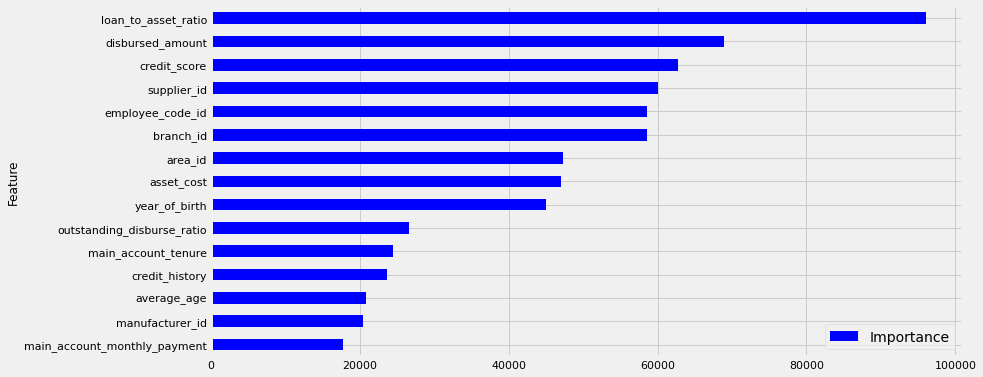

In [11]:
model = models[0]
importances = pd.DataFrame({'Feature': model.feature_name(), 
                        'Importance': model.feature_importance(importance_type='gain')})

importances.sort_values(by = 'Importance', inplace=True)
importances2 = importances.nlargest(15,'Importance', keep='first').sort_values(by='Importance', ascending=True)

importances2[['Importance', 'Feature']].plot(kind = 'barh', x = 'Feature', figsize = (12,6), color = 'blue', fontsize=11);
plt.ylabel('Feature', fontsize=12)